In [1]:
from fastai.vision.all import *
import torchvision
path=Path("/kaggle/input/lfw-yt")
files=get_image_files(path)
set_seed(0, True)
def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img

In [2]:
# 定义label_func函数
def label_func(filepath):
    return filepath.parent.name

class TripletImage(fastuple):
    def show(self, loss=None, pred=None, p=None, ctx=None, **kwargs): 
        if len(self) > 3:
                img1,img2,img3,similarity = self
        else:
            img1,img2,img3 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            if img3.size != img1.size: img3 = img3.resize(img1.size)
            t1,t2,t3 = tensor(img1),tensor(img2), tensor(img3)
            t1,t2,t3 = t1.permute(2,0,1),t2.permute(2,0,1),t3.permute(2,0,1)
        else: t1,t2,t3 = img1,img2,img3
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        if loss == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=similarity, ctx=ctx, **kwargs)
        elif pred == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{loss:.2f}", ctx=ctx, **kwargs)
        return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{pred}/{similarity} {loss:.2f} / {p:.2f}", ctx=ctx, **kwargs)

class TripletTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, f3, anchor = self.valid.get(f, self._draw(f,0))
        img1,img2,img3 = PILImage.create(f),PILImage.create(f2),PILImage.create(f3)
        return TripletImage(img1, img2, img3, anchor)
    
    def _draw(self, f, split=0):
        cls1 = label_func(f)
        cls2 = random.choice(L(l for l in labels if l != cls1))
        while len(self.lbl2files[cls2]) == 0: 
            cls2 = random.choice(L(l for l in labels if l != cls1))
        return random.choice(self.lbl2files[cls1]),random.choice(self.lbl2files[cls2]),cls1
    
@typedispatch
def show_batch(x:TripletImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): TripletImage(x[0][i], x[1][i], x[2][i], x[3][i]).show(ctx=ctx)
    
splits = RandomSplitter()(files)
labels = list(set(files.map(label_func)))
tfm = TripletTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],bs=64)

#*aug_transforms()
class TripletModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2, x3):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x3 = self.encoder(x3)
        x1 = self.head(x1)
        x2 = self.head(x2)
        x3 = self.head(x3)
        return x1, x2, x3

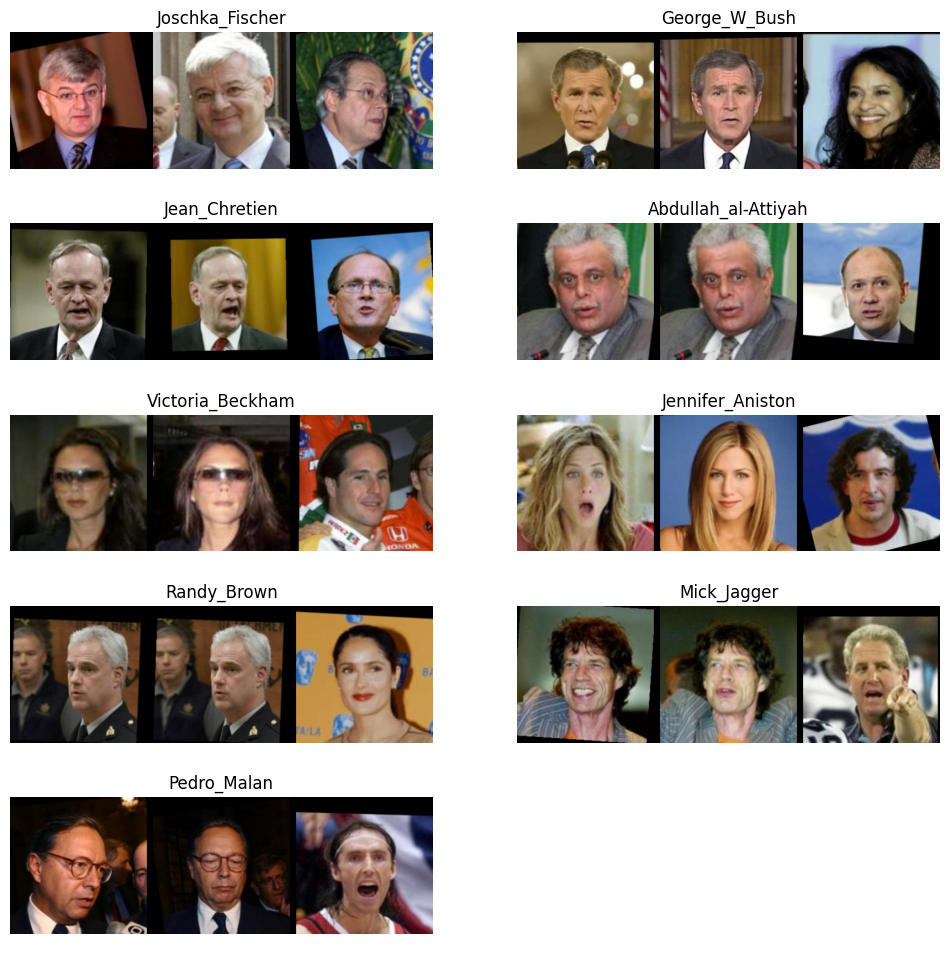

In [3]:
dls.show_batch()

In [4]:
EffNet=mobilenet_v2(weights="DEFAULT")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(EffNet, cut=-1)
head = create_head(1280, 256, [1024,512], 0.5, bn_final=True)
model = TripletModel(encoder, head)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 106MB/s] 


In [5]:
from fastai.optimizer import Adam
class _Loss(Module):
    reduction: str
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class triplet_loss_func(_Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(triplet_loss_func, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap
    def forward(self, x, *args):
        anchor, positive, negative = x[0], x[1], x[2]
        
        return F.triplet_margin_loss(anchor, positive, negative, margin=self.margin, p=self.p,
                                     eps=self.eps, swap=self.swap, reduction=self.reduction)

def triplet_splitter(model):
    return [params(model.encoder), params(model.head)]
    
def accuracy(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precison(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=5.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

learn = Learner(dls, model, loss_func=triplet_loss_func(margin=1.0), opt_func=Adam,
                splitter=triplet_splitter, metrics=[accuracy,precison,recall,f1_score],cbs=PrintBestThreshold())

In [6]:
#learn.lr_find()

In [7]:
learn.freeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,precison,recall,f1_score,time
0,0.433887,0.469473,0.720221,1.000000,0.440442,0.609163,01:41
1,0.325960,0.216738,0.749425,0.994895,0.501454,0.664581,01:26
2,0.205687,0.146290,0.832877,0.963911,0.691795,0.804086,01:22
3,0.126874,0.083611,0.907603,0.922321,0.891437,0.905934,01:20
4,0.116692,0.079535,0.909480,0.924220,0.895191,0.907536,01:20
5,0.094544,0.066422,0.919305,0.924836,0.915956,0.918833,01:23
6,0.079737,0.064447,0.928605,0.929964,0.930804,0.928668,01:20
7,0.068781,0.055603,0.934913,0.939256,0.931548,0.934505,01:20
8,0.068356,0.049533,0.938819,0.943281,0.934896,0.938330,01:22
9,0.067195,0.049604,0.940307,0.941023,0.941964,0.940354,01:19


Epoch 0 LR:0.0036819944 Best threshold: 0.10
Epoch 1 LR:0.0090616818 Best threshold: 0.10
Epoch 2 LR:0.0098933623 Best threshold: 4.73
Epoch 3 LR:0.0090525423 Best threshold: 4.82
Epoch 4 LR:0.0075110095 Best threshold: 3.80
Epoch 5 LR:0.0055353087 Best threshold: 4.75
Epoch 6 LR:0.0034670576 Best threshold: 4.30
Epoch 7 LR:0.0016638736 Best threshold: 3.87
Epoch 8 LR:0.0004375461 Best threshold: 4.05
Epoch 9 LR:0.0000001161 Best threshold: 4.02


In [8]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,precison,recall,f1_score,time
0,0.062439,0.048100,0.940865,0.938438,0.944568,0.940938,01:42
1,0.059624,0.047272,0.942167,0.942767,0.942708,0.942038,01:42
2,0.055003,0.043420,0.944027,0.945687,0.943452,0.943830,01:42
3,0.052172,0.044536,0.942725,0.950390,0.935640,0.942056,01:42
4,0.056648,0.040465,0.944399,0.952201,0.937128,0.943780,01:41
5,0.052396,0.037892,0.946259,0.946462,0.947917,0.946331,01:41
6,0.044254,0.037414,0.947934,0.946754,0.950521,0.947964,01:42
7,0.050745,0.034617,0.948120,0.945653,0.952381,0.948134,01:42
8,0.039382,0.037185,0.947376,0.942323,0.954613,0.947672,01:43
9,0.041924,0.035683,0.947748,0.936485,0.962426,0.948576,01:42


Epoch 0 LR:0.0000013060 Best threshold: 3.82
Epoch 1 LR:0.0000036993 Best threshold: 3.96
Epoch 2 LR:0.0000066659 Best threshold: 4.07
Epoch 3 LR:0.0000090725 Best threshold: 4.32
Epoch 4 LR:0.0000100000 Best threshold: 4.14
Epoch 5 LR:0.0000098921 Best threshold: 4.08
Epoch 6 LR:0.0000095703 Best threshold: 3.96
Epoch 7 LR:0.0000090488 Best threshold: 3.85
Epoch 8 LR:0.0000083504 Best threshold: 4.14
Epoch 9 LR:0.0000075055 Best threshold: 4.55
Epoch 10 LR:0.0000065512 Best threshold: 4.18
Epoch 11 LR:0.0000055290 Best threshold: 4.19
Epoch 12 LR:0.0000044837 Best threshold: 4.39
Epoch 13 LR:0.0000034610 Best threshold: 4.47
Epoch 14 LR:0.0000025056 Best threshold: 4.39
Epoch 15 LR:0.0000016591 Best threshold: 4.24
Epoch 16 LR:0.0000009587 Best threshold: 4.11
Epoch 17 LR:0.0000004350 Best threshold: 4.34
Epoch 18 LR:0.0000001107 Best threshold: 4.47
Epoch 19 LR:0.0000000001 Best threshold: 4.25


In [9]:
learn.export('mobilenetv2_ori_256Emb_TriLoss.pkl')
#learn = load_learner('.pkl', cpu=False)